In [1]:
import json
import csv
import nltk
import pandas as pd
from collections import defaultdict
import copy
import itertools
import matplotlib.pyplot as plt
import numpy as np
from pprint import pprint # For nice printing
import warnings
warnings.filterwarnings('ignore')

# NLK dependencies
# nltk.download('wordnet')
# nltk.download('omw-1.4')
# nltk.download('punkt')
# nltk.download('opinion_lexicon')
# nltk.download('sentiwordnet')
# nltk.download('averaged_perceptron_tagger')
# nltk.download('tagsets')

# Assignment 2
from nltk.corpus import wordnet as wn
from nltk import word_tokenize

# Assignment 3
from nltk.corpus import opinion_lexicon
from nltk.corpus import sentiwordnet as swn

# Assignment 4
import re

# Assignment 1

### Task 1.1 
**Loading all the hotel reviews from the Yelp hotel reviews file.**

### Task 1.2 (optional) 

**Loading line by line the reviews from the Yelp beauty/spa resorts and restaurants reviews files.**

### Task 1.3 (optional) 

**Loading line by line reviews on other domains (e.g., movies, books, phones, digital music, CDs and videogames) from McAuley’s Amazon dataset.**

We tackle all of these tasks at the same time since a general enough functions solves all of them directly. The function `load_json_line_by_line()` reads a json file line by line and returns the dataset built.

We additionally created a test function that tests the loading of all the described datasets. We have selected the Amazon cell phones and accessories dataset because it is big enough without being huge and we also have the required aspects for it (see tasks 2.1 to 2.3).

In [2]:
hotels_path = 'inputs/yelp_dataset/yelp_hotels.json'


def load_json_line_by_line(path):
    reviews = []
    with open(path, encoding='utf-8') as file:
        for line in file:
            # If line ends with a coma, remove it.
            if len(line) > 2:
                line = line[:-2] if line[-2] == ',' else line[:-1]
                reviews.append(json.loads(line))
    return reviews


def test_load_json_line_by_line():
    paths = [
        'inputs/yelp_dataset/yelp_hotels.json',
        'inputs/yelp_dataset/yelp_beauty_spas.json',
        'inputs/yelp_dataset/yelp_restaurants.json',
        'inputs/amazon/Cell_Phones_and_Accessories_5.json'
    ]

    for path in paths:
        print('Reading file {}\n'.format(path))
        reviews = load_json_line_by_line(path)
        print('{} reviews loaded\n'.format(len(reviews)))
        print('Example review: {}\n'.format(reviews[0]))


test_load_json_line_by_line()

Reading file inputs/yelp_dataset/yelp_hotels.json

5034 reviews loaded

Example review: {'reviewerID': 'qLCpuCWCyPb4G2vN-WZz-Q', 'asin': '8ZwO9VuLDWJOXmtAdc7LXQ', 'summary': 'summary', 'reviewText': "Great hotel in Central Phoenix for a stay-cation, but not necessarily a place to stay out of town and without a car. Not much around the area, and unless you're familiar with downtown, I would rather have a guest stay in Old Town Scottsdale, etc. BUT if you do stay here, it's awesome. Great boutique rooms. Awesome pool that's happening in the summer. A GREAT rooftop patio bar, and a very very busy lobby with Gallo Blanco attached. A great place to stay, but have a car!", 'overall': 4.0}

Reading file inputs/yelp_dataset/yelp_beauty_spas.json

5579 reviews loaded

Example review: {'reviewerID': 'Xm8HXE1JHqscXe5BKf0GFQ', 'asin': 'WGNIYMeXPyoWav1APUq7jA', 'summary': 'summary', 'reviewText': "Good tattoo shop. Clean space, multiple artists to choose from and books of their work are available f

# Assignment 2

### Task 2.1

**Loading (and printing on screen) the vocabulary of the `aspects_hotels.csv` file, and directly using it to identify aspect references in the reviews. In particular, the aspects terms could be mapped by exact matching with nouns appearing in the reviews.**

We will compute a dictionary that matches a certain aspect to every word related to it. It will usually be called `aspect_words_dict`. This will optimize knowing which aspect is related to each word.

The function `build_simple_vocab` creates this dictionary given a path to the file with the initial vocabulary. We introduce it in a dataframe (used only with displayability purposes) and we display the result.

In [3]:
aspect_hotels_path = 'inputs/aspects/aspects_hotels.csv'


def load_vocab(path):
    """
    Loads the vocabulary from a given csv
    """
    vocab = pd.read_csv(path, names=['aspect', 'word'])
    return vocab.groupby('aspect')['word'].apply(list)


def create_word_to_aspects_dict(aspect_words_dict):
    '''
        This function transforms an 'aspect to words'
        dictionary to a 'word to aspect' default dictionary
    '''
    word_aspect_dict = defaultdict(str)
    for aspect, words in aspect_words_dict.items():
        for word in words:
            word_aspect_dict[word] = aspect
    return word_aspect_dict


def build_simple_vocab(path):
    aspect_words_dict = load_vocab(path)
    word_aspect_dict = create_word_to_aspects_dict(aspect_words_dict)
    return word_aspect_dict


word_aspect_dict = build_simple_vocab(aspect_hotels_path)
printable = pd.DataFrame.from_dict(word_aspect_dict, orient='index')
printable.head(10)

,0
amenity,amenities
amenities,amenities
services,amenities
atmosphere,atmosphere
atmospheres,atmosphere
ambiance,atmosphere
ambiances,atmosphere
light,atmosphere
lighting,atmosphere
lights,atmosphere


In the following cells we compute the aspects referenced by each review and display the result for the first few reviews.

In [4]:
def get_text_vocabulary(text):
    '''
        Returns a list of the words from
        the given text.
    '''
    # Tokenize the text
    tokens = nltk.word_tokenize(text)

    # Obtain the words
    return [w.lower() for w in tokens if w.isalnum()]


def find_aspects_in_reviews(reviews, word_aspect_dict):
    '''
        Given a list of reviews, returns a set with the
        aspects that each review references.
    '''
    # Initialize references list
    refered_aspects = []

    for review in reviews:
        # Obtain review vocabulary
        r_vocab = get_text_vocabulary(review['reviewText'])

        # Search for words related to aspects and append
        # to vector if word appears
        refered_aspects.append(set([
            word_aspect_dict[word] for word in r_vocab if word_aspect_dict[word] != ''
        ]))

    return refered_aspects

In [5]:
hotel_reviews = load_json_line_by_line(hotels_path)
word_aspect_dict = build_simple_vocab(aspect_hotels_path)
refered_aspects = find_aspects_in_reviews(hotel_reviews, word_aspect_dict)

for review, aspects in zip(hotel_reviews[:3], refered_aspects[:3]):
    print('\tReview: {} \n\tAspects: {} \n'.format(
        review['reviewText'], aspects))

	Review: Great hotel in Central Phoenix for a stay-cation, but not necessarily a place to stay out of town and without a car. Not much around the area, and unless you're familiar with downtown, I would rather have a guest stay in Old Town Scottsdale, etc. BUT if you do stay here, it's awesome. Great boutique rooms. Awesome pool that's happening in the summer. A GREAT rooftop patio bar, and a very very busy lobby with Gallo Blanco attached. A great place to stay, but have a car! 
	Aspects: {'bar', 'shopping', 'building', 'pool', 'transportation'} 

	Review: I feel the Days Inn Tempe is best described as "a place where you can purchase the right to sleep for awhile." I booked my 10-night stay on Travelocity for a non-smoking room, yet when I entered the room I almost choked. It was disgusting. I've never had a smoking hotel room before and I will make sure I don't again. They said they couldn't move us to a different room.My local lady friend brought over a bottle of wine but forgot a co

### Task 2.2 (optional)

**Generating or extending the lists of terms of each aspect with synonyms extracted from WordNet.**

For this second task we expand the vocabulty using synonims extracted from Wordnet. The function `build_vocab()` is analogous to the previous `build_simple_vocab()` but takes this synonims into account.

In [6]:
def get_word_synonims(word):
    syns = []
    for syn in wn.synsets(word):
        for l in syn.lemmas():
            syns.append(l.name())
    return syns


def add_synonims_to_vocab(word_aspect_dict):
    '''
        Given a vocabulary, extends it by adding the synonims
        of each word.
    '''
    result = copy.deepcopy(word_aspect_dict)
    for word, aspect in word_aspect_dict.items():
        for synonym in get_word_synonims(word):
            result[synonym] = aspect
    return result


def build_vocab(path, add_synonyms = True):
    '''
        Builds a vocabulary taking synonims into account.
    '''
    aspect_words_dict = load_vocab(path)
    word_aspect_dict = create_word_to_aspects_dict(aspect_words_dict)
    word_aspect_dict_extended = add_synonims_to_vocab(word_aspect_dict)
    return word_aspect_dict_extended

### Task 2.3 (optional)

**Managing vocabularies for additional Yelp or Amazon domains. See assignments 1.2 and 1.3**

Extended our previous functions to the new datasets is trivial. We simple need to load the correct aspects for each review. The following test function computes the following for the Yelp hotels, Yelp restaurants and Amazon phones datasets:

- Load the reviews and build both the simple and complex vocabularies.
- Print the aspects found in the first few reviews with each vocabulary.
- Print the number of words in both the simple and extended vocabulary for comparison.

In [7]:
def test_expand_vocab(reviews_path, aspects_path,
                      n_displayed_reviews=3):
    '''
        This functions displayes the refered aspects in the first,
        n_displayed_reviews reviews using both vocabularies,
    '''
    reviews = load_json_line_by_line(reviews_path)

    simple_vocab = build_simple_vocab(aspects_path)
    complex_vocab = build_vocab(aspects_path)

    refered_aspects = find_aspects_in_reviews(
        reviews[:n_displayed_reviews], simple_vocab)
    refered_aspects_extended = find_aspects_in_reviews(
        reviews[:n_displayed_reviews], complex_vocab)
    for review, aspects, extended_aspects in zip(reviews[:n_displayed_reviews],
                                                 refered_aspects,
                                                 refered_aspects_extended):
        print('\tReview: {} \n\tAspects: {} \n\tExtended Vocab Aspects: {} \n'.format(
            review['reviewText'], aspects, extended_aspects))
    return simple_vocab, complex_vocab,
    _ = test_expand_vocab(hotels_path, aspect_hotels_path)

def test_build_vocabulary(n_displayed_reviews=1):
    test_case_names = [
        'Yelp hotels',
        'Yelp restaurants',
        'Amazon cell phones and accesories'
    ]
    reviews_paths = [
        'inputs/yelp_dataset/yelp_hotels.json',
        'inputs/yelp_dataset/yelp_restaurants.json',
        'inputs/amazon/Cell_Phones_and_Accessories_5.json'
    ]
    aspects_paths = [
        'inputs/aspects/aspects_hotels.csv',
        'inputs/aspects/aspects_restaurants.csv',
        'inputs/aspects/aspects_phones.csv'
    ]

    for name, reviews_path, aspects_path in \
            zip(test_case_names, reviews_paths, aspects_paths):
        print('----- {} dataset -----\n'.format(name))

        simple_vocab, complex_vocab = test_expand_vocab(
            reviews_path, aspects_path, n_displayed_reviews=n_displayed_reviews)

        print('Words in simple vocab: {}'.format(len(simple_vocab.keys())))
        print('Words in complex vocab: {}\n'.format(len(complex_vocab.keys())))


test_build_vocabulary(n_displayed_reviews=2)

----- Yelp hotels dataset -----

	Review: Great hotel in Central Phoenix for a stay-cation, but not necessarily a place to stay out of town and without a car. Not much around the area, and unless you're familiar with downtown, I would rather have a guest stay in Old Town Scottsdale, etc. BUT if you do stay here, it's awesome. Great boutique rooms. Awesome pool that's happening in the summer. A GREAT rooftop patio bar, and a very very busy lobby with Gallo Blanco attached. A great place to stay, but have a car! 
	Aspects: {'bar', 'shopping', 'building', 'pool', 'transportation'} 
	Extended Vocab Aspects: {'bedrooms', 'pool', 'bar', 'service', 'location', 'shopping', 'checking', 'building', 'transportation'} 

	Review: I feel the Days Inn Tempe is best described as "a place where you can purchase the right to sleep for awhile." I booked my 10-night stay on Travelocity for a non-smoking room, yet when I entered the room I almost choked. It was disgusting. I've never had a smoking hotel ro

From this point onwards we will focus on the hotel dataset. The hotel reviews and vocab are loaded now and fixed for the rest of this practical assignment.

In [8]:
# Load reviews
hotel_reviews = load_json_line_by_line(hotels_path)

# Build vocab for hotel reviews
word_aspect_dict = build_vocab('inputs/aspects/aspects_hotels.csv')

# Assignment 3

### Task 3.1 (mandatory)

**Loading Liu’s opinion lexicon composed of positive and negative words, accessible as an NLKT corpus, and exploiting it to assign the polarity values to aspect opinions in assignment 4.**

We decided to load not only Liu's lexicon but also `Vader` lexicon. Also, we used `SentiWordNet`, but we do not need to load it in advance to its usage, so we directly use it in the code.

In [10]:
def load_polarities():
    # Liu's opinion lexicon
    pos_list = set(opinion_lexicon.positive())
    neg_list = set(opinion_lexicon.negative())

    adj_polarities = defaultdict(float)
    for word in pos_list:
        adj_polarities[word] = 1.0
    for word in neg_list:
        adj_polarities[word] = -1.0
        
    return adj_polarities

def vader_lexicon():
    f = nltk.data.load("inputs/vader_lexicon/vader_lexicon.txt")
    lexicon = defaultdict(float)
    for line in f.split("\n"):
        (word, polarity) = line.strip().split("\t")[0:2]
        lexicon[word] = float(polarity)
        
    return lexicon
        
    

adj_polarities = load_polarities()
adj_polarities_vader = vader_lexicon()
list( adj_polarities.items() )[:10]

[('impartial', 1.0),
 ('unwavering', 1.0),
 ('idealize', 1.0),
 ('proficiently', 1.0),
 ('astonishment', 1.0),
 ('wonderous', 1.0),
 ('punctual', 1.0),
 ('enviously', -1.0),
 ('dignify', 1.0),
 ('fastest-growing', 1.0)]

### Task 3.2 (optional)

**Considering modifiers to adjust the polarity values of the aspect opinions in Assignment 4.**

In [11]:
def load_modifiers(path='./inputs/modifiers/modifiers.csv'):
    mod = pd.read_csv(path, sep=',', header=None, names=['mod', 'val'])
    modifiers = {row[0]: row[1] for _, row in mod.iterrows()}
    
    # Manually add the modifier '', which doesn't modify
    modifiers[''] = 1.0
    
    return modifiers

modifiers = load_modifiers()
list( modifiers.items() )[:10]

[('above', 2.0),
 ('absolutely', 2.0),
 ('abundantly', 2.0),
 ('acutely', 2.0),
 ('amazingly', 2.0),
 ('amply', 2.0),
 ('assiduously', 2.0),
 ('astonishingly', 2.0),
 ('awfully', 2.0),
 ('beyond', 2.0)]

# Assignment 4

Once the aspect vocabulary and opinion lexicons are loaded, the opinions about aspects have to be extracted from the reviews. For this purpose, POS tagging, constituency and dependency parsing could be used.
- POS tagging would allow identifying the adjectives in the sentences.
- Constituency and dependency parsing would allow extracting the relations between nouns and adjectives and adverbs.

The following tasks are proposed:

- **Task 4.1 (mandatory)**: extracting the `[aspect, aspect term, opinion word, polarity]` tuples from the input reviews
- **Task 4.2 (optional)**: extracting the `[aspect, aspect term, opinion word, modifier, polarity]` tuples from the input reviews, taking the modifiers of assignment 3.2
- **Task 4.3 (optional)**: extracting the `[aspect, aspect term, opinion word, isNegated, polarity]` tuples from the input reviews, taking the modifiers of assignment 3.3

We firstly create code to extract the asked tuples. This is no more than joining (with a little bit of care) all the code that we have previously developed. We also parts of the code provided in the assignment. We begin by creating a function that returns the POS tagging for a given text, and we test it.

In [13]:
def pos_tagging(text):
    sentences = nltk.sent_tokenize(text)
    sentences = [nltk.word_tokenize(s) for s in sentences]
    sentences = [nltk.pos_tag(s) for s in sentences]
    return sentences

In [14]:
print(pos_tagging("I think you are very handsome."))

[[('I', 'PRP'), ('think', 'VBP'), ('you', 'PRP'), ('are', 'VBP'), ('very', 'RB'), ('handsome', 'JJ'), ('.', '.')]]


In [15]:
def aspect_opinions_from_sentence(tokenized_sentence, word_aspect_dict, adj_polarities, modifiers, method='Liu'):
    result = []
    for child in tokenized_sentence:
        if not isinstance(child, nltk.Tree) or child.label() != 'JJNN':
            continue

        # Obtain the nouns referenced
        aspect_terms = [x[0] for x in child if x[1].startswith('NN')]

        # Keep only the nouns with associated aspect. If non, skip loop iteration
        aspect_terms = [x for x in aspect_terms if x in word_aspect_dict]
        if len(aspect_terms) == 0:
            continue

        # Obtain the adjetives referencing the nouns
        opinion_words = [x[0] for x in child if x[1].startswith('JJ')]

        # Obtain the adverbs and compute whether the sentence is negated
        adverbs = [x[0] for x in child if x[1].startswith('RB')]
        negated = -1 if ('not' in adverbs or 'n\'t' in adverbs) else 1

        # Obtain the modifiers: adverbs present in our modifiers list
        mod_list = [x for x in adverbs if x in modifiers]

        # If there are no modifiers, add the trivial modifier '' to the list
        if len(mod_list) == 0:
            mod_list = ['']

        # Compute polarity following each method
        if method == 'Liu':
            computed_polarities = [adj_polarities[word]
                                   for word in opinion_words]
        elif method == 'SentiWordNet':
            computed_polarities = []
            for w in opinion_words:
                if len(list(swn.senti_synsets(w, pos='a'))) > 0:
                    computed_polarities.append(list(swn.senti_synsets(w, pos='a'))[0].pos_score() -
                                   list(swn.senti_synsets(w, pos='a'))[0].neg_score())
                else:
                    computed_polarities.append(0.0)
        elif method == 'Vader':
            computed_polarities = [adj_polarities_vader[word]
                                   for word in opinion_words]

        # Compute tuples by cycling through all combinations of noun + adjetives
        tuples = [
            (word_aspect_dict[asp_term],
             asp_term,
             opin_w,
             'negated' if negated == -1.0 else 'not negated',
             mod,
             negated * modifiers[mod] * pol)
            for asp_term, opin_w, mod, pol
            in itertools.product(aspect_terms, opinion_words, mod_list, computed_polarities)
        ]

        # Save computed tuples
        result += tuples

    return result


def clean_text(text):
    text = text.replace("<br />", " ")
    text = text.replace("\[?\[.+?\]?\]", " ")
    text = text.replace("-", " ")
    text = text.replace("\d+\&\#\d+?;", " ")
    text = text.replace("\&\#\d+?;", " ")
    text = re.sub(r'([a-zA-z])(\.)([a-zAZ])', r"\1 \3", text)
    text = text.lower()
    return text


def aspect_opinions_from_review(review_text, word_aspect_dict, adj_polarities, modifiers, grammar, method='Vader'):
    grammar_parser = nltk.RegexpParser(grammar)
    tagged_sentences = pos_tagging(review_text.lower())

    result = []
    for sentence in tagged_sentences:
        tokenized_sentence = grammar_parser.parse(sentence)
        tuples = aspect_opinions_from_sentence(
            tokenized_sentence,
            word_aspect_dict,
            adj_polarities,
            modifiers,
            method=method
        )
        result += tuples

    return result

Exploring a few examples, we found the following **difficulty**: some adjectives were not detected as adjectives since the first letter was uppercased. We decided to **lowercase** the review text. It could be interesting to see if more preprocessing to the text could improve the results. 

**Note.-** A list of possible returned POS tags returned by NLTK can be found [here](https://stackoverflow.com/questions/15388831/what-are-all-possible-pos-tags-of-nltk).

We define a grammar that tries to capture:

- (Adverb) + Adjective + Noun
- Noun + Verb + (Adverb) + Adjective

We test in very simple examples.

In [16]:
# GRAMMAR TESTING
grammar = r"""
JJNN: {<RB.*>*<JJ.*>+<NN.*>+} # adjectives escorting nouns
      {<NN.*>+<VB.*><RB.*>*<JJ.*>+} # description sentences
"""

sentences = [
    'The place is perfect',
    'The place is absolutely perfect',
    'The place isn\'t perfect',
    'The place isn\'t absolutely perfect',
    'The pool is great'
]


def test_grammar(sentences, grammar=grammar):
    for sentence in sentences:
        grammar_parser = nltk.RegexpParser(grammar)
        tokenized_sentence = grammar_parser.parse(
            pos_tagging(sentence.lower())[0])

        print('Sentence: ', sentence)
        pprint(aspect_opinions_from_sentence(tokenized_sentence,
               word_aspect_dict, adj_polarities, modifiers, method='Vader'))
        print('')


test_grammar(sentences)

Sentence:  The place is perfect
[('location', 'place', 'perfect', 'not negated', '', 2.7)]

Sentence:  The place is absolutely perfect
[('location', 'place', 'perfect', 'not negated', 'absolutely', 5.4)]

Sentence:  The place isn't perfect
[('location', 'place', 'perfect', 'negated', '', -2.7)]

Sentence:  The place isn't absolutely perfect
[]

Sentence:  The pool is great
[('pool', 'pool', 'great', 'not negated', '', 3.1)]



We can apreciate that the grammar is working well in all the proposed tests but in the last one. In this case, our grammar is not capturing the adjective "perfect" as an adjective. Let us see what `pos_tagging` returns:

In [17]:
pos_tagging("The place isn\'t absolutely perfect")

[[('The', 'DT'),
  ('place', 'NN'),
  ('is', 'VBZ'),
  ("n't", 'RB'),
  ('absolutely', 'RB'),
  ('perfect', 'VB')]]

As we can see, the problem is that the *POS Tagger* indicates that `perfect` is a verb. In this case, this is obviously not true, so it would be very interesting to use a different tagger in future projects.

We now test the proposed code in the hotel reviews:

In [18]:
def test_aspect_opinions(first_n=3, grammar=grammar):

    for review in hotel_reviews[:first_n]:
        review_text = review['reviewText']
        print('Review text: ', review_text, '\n')
        pprint(aspect_opinions_from_review(review_text, word_aspect_dict,
               adj_polarities, modifiers, grammar, method='SentiWordNet'))
        print('')


test_aspect_opinions()

Review text:  Great hotel in Central Phoenix for a stay-cation, but not necessarily a place to stay out of town and without a car. Not much around the area, and unless you're familiar with downtown, I would rather have a guest stay in Old Town Scottsdale, etc. BUT if you do stay here, it's awesome. Great boutique rooms. Awesome pool that's happening in the summer. A GREAT rooftop patio bar, and a very very busy lobby with Gallo Blanco attached. A great place to stay, but have a car! 

[('shopping', 'boutique', 'great', 'not negated', '', 0.0),
 ('bedrooms', 'rooms', 'great', 'not negated', '', 0.0),
 ('pool', 'pool', 'awesome', 'not negated', '', 0.75),
 ('building', 'patio', 'great', 'not negated', '', 0.0),
 ('bar', 'bar', 'great', 'not negated', '', 0.0),
 ('building', 'lobby', 'busy', 'not negated', 'very', 0.75),
 ('building', 'lobby', 'busy', 'not negated', 'very', 0.75),
 ('location', 'place', 'great', 'not negated', '', 0.0)]

Review text:  I feel the Days Inn Tempe is best des

In this case, we can again observe the problems that the POS tagger  causes. In the second shown opinion, we see that **non adjective words are detected as adjectives**. Furthermore, *sequences of characters* ("is.the") that are not even words are marked as adjectives. Clearly, the *non-words* problem could be solved with **text-preprocessing**, but we would need expert information to be able to determine which kind of preprocessing should be done. Also, this would not fix the problem of the POS tagger tagging incorrectly the words.

# Assignment 5

To validate and evaluate the solutions implemented in previous tasks, you are finally proposed the following tasks:

### Task 5.1 (mandatory)

**Visualizing on screen the aspect opinions (tuples) of a given review.**

In [19]:
def plot_aspects(opinions, ax = None, method_name = 'Liu'):
    if ax == None:
        figure = plt.figure()
        ax = fig.add_axes([0,0,1,1])
    _ = ax.bar(opinions.keys(), opinions.values(), 
           color=plt.cm.rainbow(np.linspace(0, 1, len(opinions))))
    if len(opinions) > 5:
        for tick in ax.get_xticklabels():
            tick.set_rotation(70)
    
    ax.set_title("Method: {}".format(method_name))

def group_review_opinions(aspect_opinions):
    grouped_opinions = defaultdict(int)
    for opinion in aspect_opinions:
        grouped_opinions[ opinion[0] ] += opinion[-1]
    return grouped_opinions
    
def plot_review_aspects(review_text, methods = ['Liu', 'SentiWordNet', 'Vader']):
    
    
    fig, axes = plt.subplots(1, len(methods), figsize = (20,5))
    
    for i,method in enumerate(methods):
       
        aspect_opinions = aspect_opinions_from_review(
            review_text,
            word_aspect_dict,
            adj_polarities,
            modifiers,
            grammar,
            method = method
            )
        grouped_opinions = group_review_opinions(aspect_opinions)
        if len(methods) == 1:
            _ = plot_aspects(grouped_opinions, axes, method_name = method)
        else:
            _ = plot_aspects(grouped_opinions, axes[i], method_name = method)
        
        
    print('Review text: ', review_text, '\n')
    _ =plt.show()



Review text:  My wife and I decided to take a little vaca to celebrate our 13th anniversary and also was the first time that we were traveling with our 5-month old, so you can imagine we were a little apprehensive. The resort is absolutely top-notch, the rooms are very spacious, the staff is very courteous, and the facilities are simply superb. Our room overlooked the mountain, and in the morning, it was blissful to sit outside and sip on our cups of joe. The rooms have a microwave and a small fridge, something that was invaluable to us to store milk and warm it up for our little one. The spa is simply one of the best in the valley, and even if you don't stay here, I would recommend the spa to anyone. The resort is close to at least 20 golf courses, something that might be important to other golf nuts like me. So then why not 5 stars? Simply because they would not extend the check-out time for us by even an hour. The check-out is 11 am and our flight was delayed to 8 pm, so when I requ

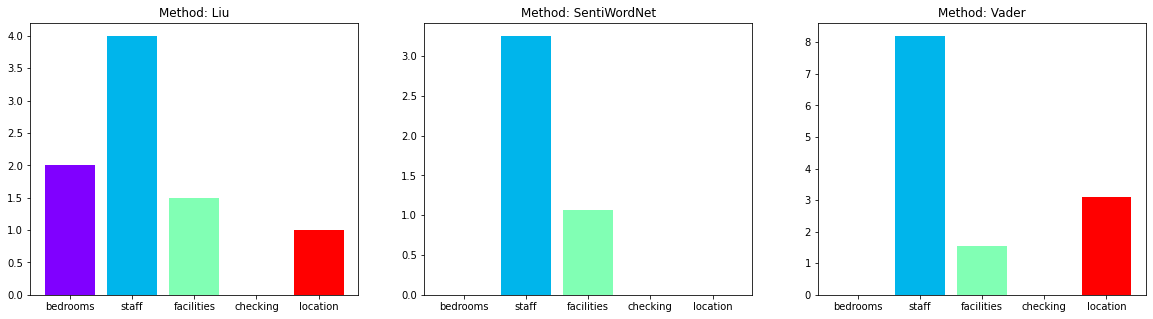

Review text:  I dug this place. Got a great deal from Priceline, and I pretty much knew what to expect going in. I've stayed at places like this before across the country, and I can definitely say that this was a very pleasant experience. Everyone has complained about the beds being hard, but I didn't really find this to be the case. I like a firmer mattress, so I guess that's just my personal preference, but it wasn't like sleeping on a campus futon or anything. The towels were nice- nothing fancy, but definitely not the thin washed-out wisps of cloth that you might have expected at other places. The setup of the place was great- it's just like having a little studio apartment. Even had a coffeemaker, and an ironing board, which is strangely becoming a rarity these days.I have to make special mention of one thing- the pillows, for some reason, were absolutely amazing. My girlfriend and I both agreed (and we're both flight attendants, so we KNOW hotels) that these were some of the best

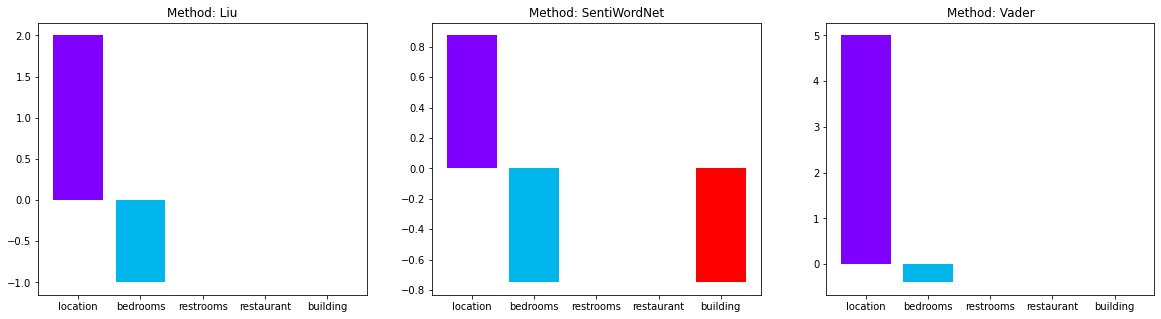

In [20]:
plot_review_aspects(hotel_reviews[2]['reviewText'])
plot_review_aspects(hotel_reviews[40]['reviewText'])

### Task 5.2 (optional)

**Visualizing on screen a summary of the aspect opinions of a given item. Among other issues, the total number of positive/negative opinions for each aspect of the item could be visualized**.


Two types of visualizations are proposed.

#### Complete Hotel Plot

The first one follows the previous approach we plot the aspect and polarities in a single review. What we do is to **sum** the polarities per aspect in each of the reviews to plot all the extracted aspects and polarities for a single hotel, given by its `isin`, which is an identifier.


In [21]:
def plot_hotel_aspects(fixed_hotel_reviews,  methods = ['Liu', 'SentiWordNet', 'Vader']):
    
    aspects_per_opinion = []
    fig, axes = plt.subplots(len(methods),1, figsize = (20,30))
    for i,method in enumerate(methods):
        opinions = []
        for review in fixed_hotel_reviews:
            review_opinions = aspect_opinions_from_review(
                review['reviewText'],
                word_aspect_dict,
                adj_polarities,
                modifiers,
                grammar,
                method = method
            )
            opinions.append(review_opinions)
    
        aspects_per_opinion.append(opinions)
        opinions = list( itertools.chain(*opinions) )
        grouped_opinions = group_review_opinions(opinions)
        if len(methods) == 1:
            plot_aspects(grouped_opinions, ax = axes, method_name = method)
        else:
            plot_aspects(grouped_opinions, ax = axes[i],method_name = method)
            
    return aspects_per_opinion

Selected 102 opinions for this hotel


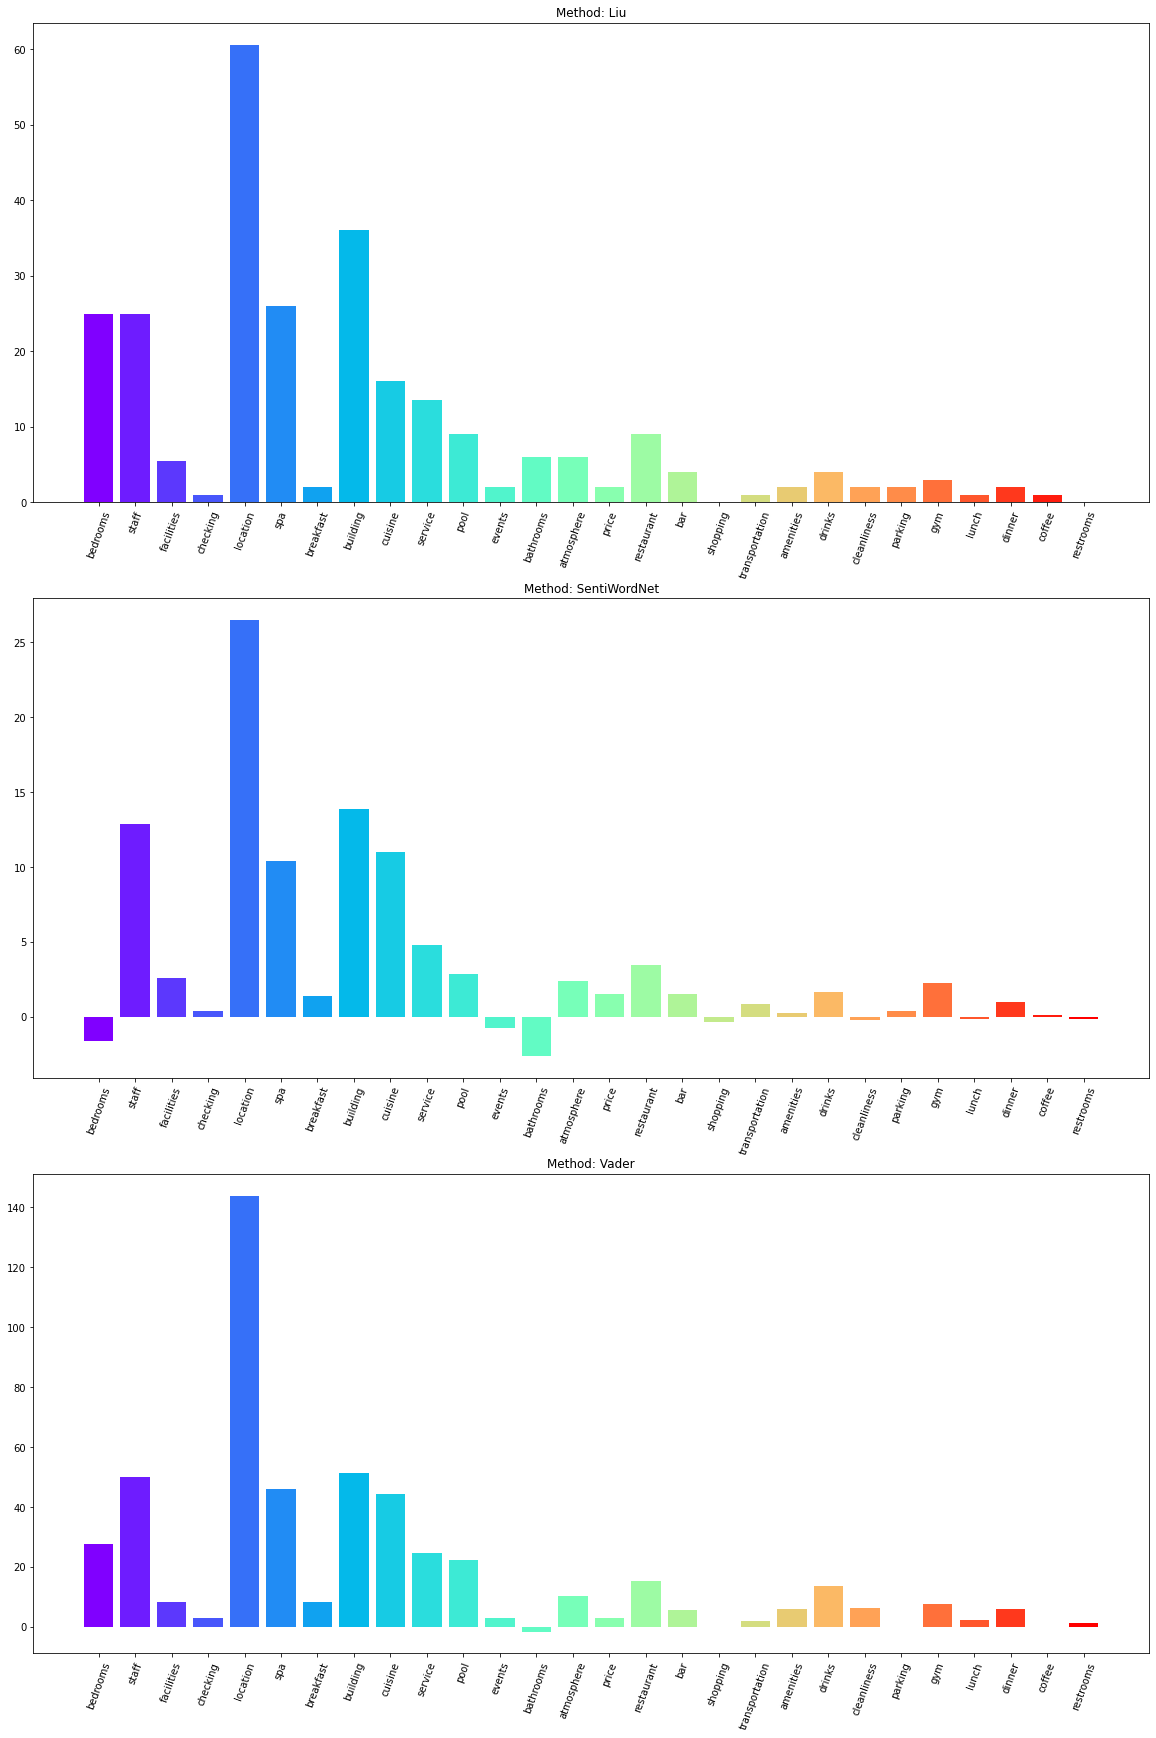

In [22]:
# Fixed an asin (the ID associated to a hotel)
fixed_asin = hotel_reviews[2]['asin']
fixed_hotel_reviews = [ x for x in hotel_reviews if x['asin'] == fixed_asin ]
print("Selected {} opinions for this hotel".format(len(fixed_hotel_reviews)))

aspects_per_opinion = plot_hotel_aspects(fixed_hotel_reviews)

As we can see, the opinions on this hotel agree in the location of the hotel. We can see the little differences between the polarity methods, where in the `SentiWordNet` method the negatives seem to have a bigger impact on the final bar plot.

Let us see another hotel with a smaller number of reviews.

Selected 5 opinions for this hotel


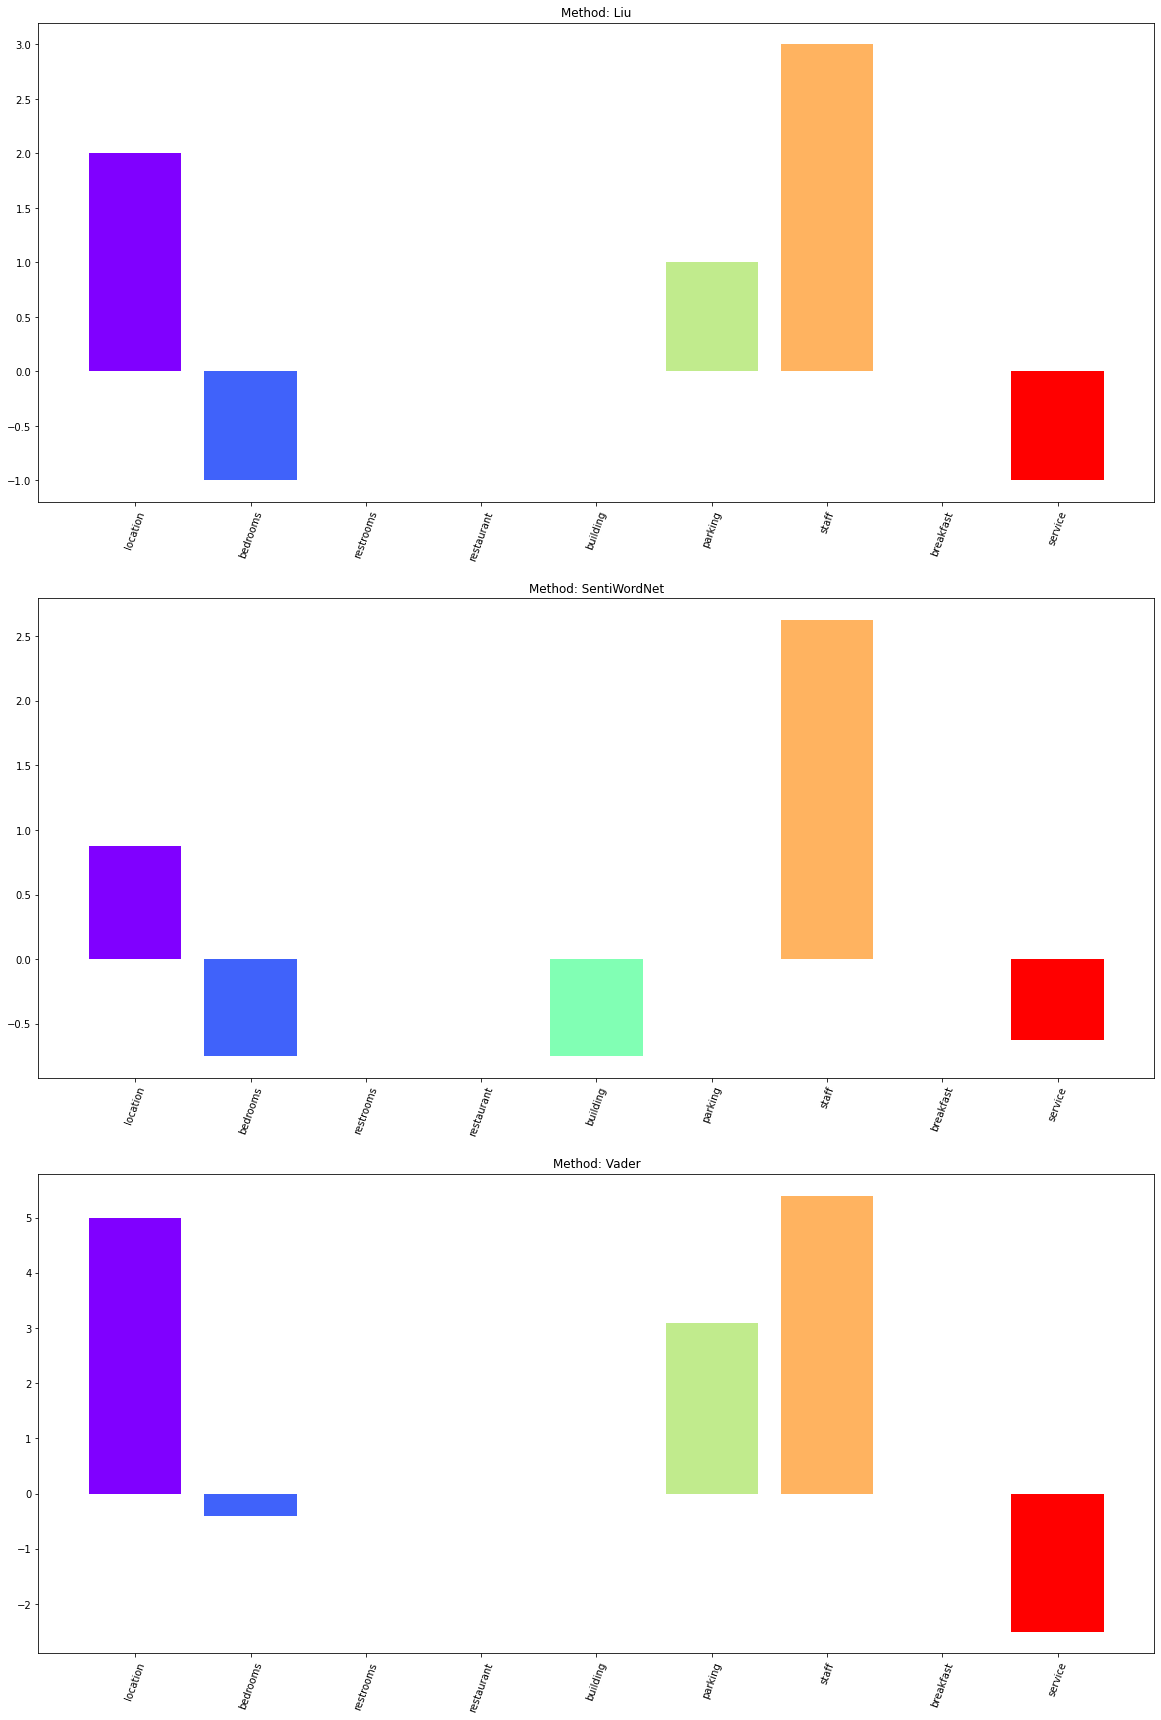

In [23]:
# Fixed an asin (the ID associated to a hotel)
fixed_asin = hotel_reviews[40]['asin']
fixed_hotel_reviews = [ x for x in hotel_reviews if x['asin'] == fixed_asin ]
print("Selected {} opinions for this hotel".format(len(fixed_hotel_reviews)))

aspects_per_opinion_2 = plot_hotel_aspects(fixed_hotel_reviews)

In this case, we can see a difference in the polarities in the aspect `building`, since SentiWordNet assigns a lower polarity in any of the reviews.

#### Numerical statistics about the reviews

The last case would be to design a code that is capable to **summarize** all the positive and negative opinions about an aspect given a certain Hotel. The code developed returns the, for **each** of the polarity assignment methods, the following values: 

- `single_positive`, indicating the total number of reviews that say **at least** one positive thing about the aspect.
- `single_negative`, the same as the previous one but saying negative things.
- `total_positive` and `total_negative`, which is the sum of total positive/negative things said about that aspect
- `average_positive/negative` the average polarity of all positive and negative comments done.

We can see the output for both previous case, using the one with lesser number of reviews first:

In [24]:
def count_aspects_opinion(aspect_opinions, aspects, methods=['Liu', 'SentiWordNet', 'Vader']):
    """
    Given the aspect opinions obtained for the three methods available,
    and a list of aspects, returns number of comments having a positive comment, 
    number of comments having a negative comment
    """
    statistics = []
    aspect_opinions = np.array(aspect_opinions)
    # Obtain statistics for each aspect given
    for aspect in aspects:
        aspect_dict = defaultdict(lambda: defaultdict(float))
        # Obtain opinions speaking about an aspect
        idx = np.array([True if aspect in np.array(opinion).flatten()
                        else False for opinion in aspect_opinions[0]], dtype=int)
        idx = np.where(idx == 1)[0]
        # For each method
        for method, name in zip(range(len(methods)), methods):
            # Get opinions
            opinions = aspect_opinions[method][idx]

            all_positive = np.array([])
            all_negative = np.array([])

            for opinion in opinions:
                opinion = np.array(opinion)
                # Select tuples about aspect
                idx_tuples = np.where(np.array(opinion) == aspect)[0]
                # Obtain positive and negative values
                positive_values = [
                    float(t[-1]) if float(t[-1]) > 0.0 else 0 for t in opinion[idx_tuples]]
                positive_values = list(
                    filter(lambda x: x > 0.0, positive_values))
                negative_values = [
                    float(t[-1]) if float(t[-1]) < 0.0 else 0 for t in opinion[idx_tuples]]
                negative_values = list(
                    filter(lambda x: x < 0.0, negative_values))
                # Save statistics
                aspect_dict[name]['single_positive'] += 1 if len(
                    positive_values) > 0 else 0
                aspect_dict[name]['single_negative'] += 1 if len(
                    negative_values) > 0 else 0

                aspect_dict[name]['total_positive'] += len(positive_values)
                aspect_dict[name]['total_negative'] += len(negative_values)

                all_positive = np.append(all_positive, positive_values)
                all_negative = np.append(all_negative, negative_values)

            aspect_dict[name]['average_positive'] = np.nan_to_num(np.mean(all_positive))
            aspect_dict[name]['average_negative'] = np.nan_to_num(np.mean(all_negative))

        statistics.append(aspect_dict)

    return statistics


def show_statistics_per_aspect(hotel_name, aspects, dicts):
    print("Statistics found for hotel: {}".format(hotel_name))
    for aspect, results in zip(aspects, dicts):
        print("Aspect: {}".format(aspect))
        df = pd.DataFrame.from_dict(results)
        print(df)
        print()

In [25]:
aspects = ['location','bedrooms', 'service']
hotel_name = fixed_asin = hotel_reviews[40]['asin']
counts = count_aspects_opinion(aspects_per_opinion_2, aspects)
show_statistics_per_aspect(hotel_name, aspects, counts)

Statistics found for hotel: CYMG5AsrhkhUPro2c6NSUA
Aspect: location
                  Liu  SentiWordNet  Vader
single_positive   1.0         1.000    1.0
single_negative   0.0         0.000    0.0
total_positive    2.0         1.000    2.0
total_negative    0.0         0.000    0.0
average_positive  1.0         0.875    2.5
average_negative  0.0         0.000    0.0

Aspect: bedrooms
                  Liu  SentiWordNet  Vader
single_positive   0.0          0.00    0.0
single_negative   1.0          1.00    1.0
total_positive    0.0          0.00    0.0
total_negative    1.0          1.00    1.0
average_positive  0.0          0.00    0.0
average_negative -1.0         -0.75   -0.4

Aspect: service
                  Liu  SentiWordNet  Vader
single_positive   0.0         0.000    0.0
single_negative   1.0         1.000    1.0
total_positive    0.0         0.000    0.0
total_negative    1.0         1.000    1.0
average_positive  0.0         0.000    0.0
average_negative -1.0        -0.625  

We can see how the service has the highest value of negative polarity, as we saw in the charts.

In the first case analyzed before, we obtain the following result:

In [26]:
hotel_name = fixed_asin = hotel_reviews[2]['asin']
counts = count_aspects_opinion(aspects_per_opinion, aspects)
show_statistics_per_aspect(hotel_name, aspects, counts)

Statistics found for hotel: EcHuaHD9IcoPEWNsU8vDTw
Aspect: location
                        Liu  SentiWordNet      Vader
single_positive   36.000000     29.000000  33.000000
single_negative    3.000000      4.000000   3.000000
total_positive    65.000000     53.000000  57.000000
total_negative     4.000000      5.000000   4.000000
average_positive   1.146154      0.650943   3.042982
average_negative  -1.000000     -0.600000  -2.000000

Aspect: bedrooms
                        Liu  SentiWordNet      Vader
single_positive   20.000000     15.000000  13.000000
single_negative    1.000000     12.000000   1.000000
total_positive    23.000000     15.000000  14.000000
total_negative     1.000000     15.000000   1.000000
average_positive   1.130435      0.433333   2.135714
average_negative  -1.000000     -0.541667  -2.300000

Aspect: service
                        Liu  SentiWordNet      Vader
single_positive   16.000000      10.00000  12.000000
single_negative    4.000000       4.00000   2.000

# Conclusion

After all this work, a few conclusions have been extracted:

- Defining a complete grammar is complicated. In natural language, there are many possible cases of use of our words, so most of the time it is impossible to capture them all in a grammar. We decided to use a simple grammar for simplicity of analyzing our problems.
- The POS tagger determines the quality of our analysis, since sometimes it captures wrong tags for certain words, which causes problems with the posterior analysis.
- Also, the final polarity value depends on the used lexicon. Although sometimes the values are coincident, most of the times the polarity values vary between the lexicons, making our method less robust to a change of lexicon.

However, we already know that this specific method of extracting aspects of a text and the polarities of the aspect is outdated and that the state of art methods clearly outperform the accuracy and correctness of the aspect extraction.